# Photogrammetry: Part 1

Reading: Szeliski Ch. 7

Video Lecture: https://youtu.be/4cS8-b30X54 (Not Mubarak Shah.  His lecture on this topic is incomprehensible and outdated)


## Inverting the Camera model

You'll recall that back in Project 1, I put a "bonus" problem at the bottom.  The question posed was thus:

A calibrated camera model is a non-linear function that maps from a 3D coordinate system to a 2D coordinate system.  Can this function be inverted?  Can you, based on a 2D image of an object, recover that object's 3D coordinates?  

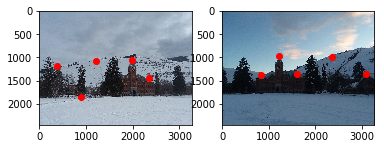

In [5]:
import numpy as np
import matplotlib.pyplot as plt

I_1 = plt.imread('campus_stereo_1.jpg')
I_2 = plt.imread('campus_stereo_2.jpg')

gcp_1 = np.loadtxt('gcp_stereo_1.txt',delimiter=',')
gcp_2 = np.loadtxt('gcp_stereo_2.txt',delimiter=',')

fig,axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(I_1)
axs[0].plot(gcp_1[:,0],gcp_1[:,1],'ro')

axs[1].imshow(I_2)
axs[1].plot(gcp_2[:,0],gcp_2[:,1],'ro')

plt.show()

Calibrating camera models is easy: we have already produced code that allows us to do it.  You'll remember that the solution to this problem is essentially a *non-linear* least squares problem, the solution of which is the optimal camera pose $\mathbf{p}_{opt}$:
$$
\mathbf{p}_{opt} = \mathrm{argmin}_{\mathbf{p}} \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^2 (f(\mathbf{X}_i,\mathbf{p})_j - \mathbf{u}_{ij})^2,
$$
where $n$ is the number of GCPs, and $f(\mathbf{X},\mathbf{p})$ is the projection of real world coordinates $\mathbf{X}$ into camera coordinates (which depends on the pose $\mathbf{p}$, and $\mathbf{u}$ is the pixel coordinates of the equivalent point in the image.

Stated plainly, the objective function above corresponds to the situation in which the real world coordinates of ground control points and their locations in the image are known, while the camera parameters are unknown (and are what we are trying to determine).  What we would like to do is to write an objective function for the converse situation, in which the camera parameters are known, the position of a desired object in an image is known, but the real world coordinates are unknown (and are what we are trying to determine).  Such an objective function might look like this:
$$
\mathbf{X}_{opt} = \mathrm{argmin}_{\mathbf{X}} \frac{1}{2} \sum_{j=1}^2 (f(\mathbf{X},\mathbf{p})_j - \mathbf{u}_j)^2,
$$
where $X_{opt}$ is the position of an object in real world coordinates, $\mathbf{u}$ is its known coordinates in the image, and $\mathbf{p}$ is a known camera model.  Unfortunately, using this objective function is doomed to failure.  Why can't this work?  Counting the number of data points, we find that there are two, the two components of $\mathbf{u}$.  However, the vector $\mathbf{X}$ has three components.  The system is underdetermined: we can only determine $\mathbf{X}$ up to a constant scaling factor.  

How can we make this system of equations over-determined instead?  We can use more cameras, of course.  How does this affect the objective function: 
$$
\mathbf{X}_{opt} = \mathrm{argmin}_{\mathbf{X}} \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^2 (f(\mathbf{X},\mathbf{p}_i)_j - \mathbf{u}_{ij})^2,
$$
where $m$ is the number of cameras, $\mathbf{p}_i$ is the known pose of camera $i$, and $\mathbf{u}_i$ is the location of the feature of interest in the image corresponding to camera $i$.  As in the case of solving for pose, this problem can be solved using Levenburg-Marquardt.  

## Assignment
**In the project file you will find two images (campus_stereo_1.jpg and campus_stereo_2.jpg), with two sets of ground control points (gcp_stereo_1.jpg and gcp_stereo_2.jpg).  Optimze a camera model for each image.  Using both these camera models, implement the optimization problem defined above for determining the [Easting,Northing,Elevation] position of the central pivot on the main hall clock.**

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.optimize as so

# Class for our camera model
class Camera(object):
    def __init__(self):
        self.p = None                   # Pose
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # Sensor
        
    def projective_transform(self,x):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        """
        focal = self.f
        sensor = self.c
        
        #General Coordinates
        gcx = x[0]/x[2]
        gcy = x[1]/x[2]
        
        #Pixel Locations
        pu = gcx*focal + sensor[0]/2.
        pv = gcy*focal + sensor[1]/2.
        
        return np.array([pu,pv])
      
    
    def rotational_transform(self,X,pts):
        """  
        This function performs the translation and rotation from world coordinates into generalized camera coordinates.
        """
        
        cam_x = X[0]
        cam_y = X[1]
        cam_z = X[2]
        roll = X[3]
        pitch = X[4]
        yaw = X[5]
        
        r_axis = np.array([[1, 0, 0], [0, 0,-1], [0, 1, 0]])
        r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], [0, 1, 0], [np.sin(roll), 0, np.cos(roll)]])
        r_pitch = np.array([[1, 0, 0], [0, np.cos(pitch), np.sin(pitch)], [0, -1*np.sin(pitch), np.cos(pitch)]])
        r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], [np.sin(yaw), np.cos(yaw), 0, 0], [0, 0, 1, 0]])

        T = np.array([[1, 0, 0, -cam_x],[0, 1, 0, -cam_y], [0, 0, 1, -cam_z], [0, 0, 0, 1]])
        
        C = r_axis @ r_roll @ r_pitch @ r_yaw @ T

        return C @ pts
    
    def rotational_transform_x(self, X):
        """
        This function performs the translation and rotation from world coordinates into generalized camera coordinates.
        """

        # Unpack pose? could do something different here.
        X_cam, Y_cam, Z_cam, azimuth_cam_deg, pitch_cam_deg, roll_cam_deg = self.p

        # Make X a set of homogeneous coors
        X = np.vstack((X, np.ones(X.shape[1])))

        # Convert degrees to radians
        azimuth_cam_rad = np.deg2rad(azimuth_cam_deg)
        pitch_cam_rad = np.deg2rad(pitch_cam_deg)
        roll_cam_rad = np.deg2rad(roll_cam_deg)

        translation_vec = [X_cam, Y_cam, Z_cam]
        C = self.make_cam_mtx(azimuth_cam_rad, pitch_cam_rad, roll_cam_rad, translation_vec)

        return C @ X
    
    def estimate_pose(self,gcps):
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """
        p_opts = [] # Initial easting, northing, elevation positions
        u_gcps = [] # Initial projected u,v coordinates

        for gcp in gcps:
            pts = gcp[2:5]
            # Add homogenous coordinate
            pts= np.append(pts, 1)

            # Observed pixel coordinates
            u_gcp = gcp[0:2]
            p_opts.append(pts)
            u_gcps.append(u_gcp)
    
        ave_easting = np.mean([gcp[2] for gcp in gcps])
        ave_northing = np.mean([gcp[3] for gcp in gcps])
        ave_elevation = np.mean([gcp[4] for gcp in gcps])
            
        # Initial guess at the pose
        p0 = np.array([ave_easting, ave_northing, ave_elevation,90,45,45])
        
        # print(p0, '\n', p_opts, '\n', u_gcps, '\n')
        
        # Find the optimal pose minimizing the residual
        p_opt = so.least_squares(self.residual, p0, method='lm', args=(p_opts,u_gcps))['x']
        
        self.p = p_opt
        
    # Function to transform all gcps into the camera coordinates
    def transform_all(self,X_gcp, p):
        transformed = []
        
        for gcp in X_gcp:
            # Perform rotational transform on X_gcp
            rotated = self.rotational_transform(p, gcp)
            
            # Project the rotated coordinates to pixel coordinates
            projected = self.projective_transform(rotated)
            transformed.append(projected)

        return transformed
    
    # Calculate the difference in the estimate projection of X_gcp and actual positions of u_gcp
    def residual(self, p0, X_gcp, u_gcp):
        all_res = np.array(self.transform_all(X_gcp, p0)) - np.array(u_gcp)
        all_res = all_res.ravel()
        
        return all_res
    
    def cam_to_ene(self, u):
        return self.projective_transform(self.rotational_transform_x(u))

In [2]:
# Estimates the world coordinates of a specific point in multiple images
def world_coordinate_estimation(camera_list, u_list):
    residuals = np.empty(camera_list.shape[0])

    # Computes the residual: X - guess of world coordinates, c - a camera object, u - pixel coordinates of a point
    def residual(X, camera, u):
        xuv = camera.cam_to_ene(X)
        res = xuv - u_list[c]

        return res

    for c in range(camera_list.shape[0]):
        x = camera_list[c].p
        residuals[c] = so.least_squares(residual, x, args=(camera_list[c], u_list[c]))
    return res

In [3]:
import PIL.Image

def get_focallength_x_and_y(img):
    with PIL.Image.open(img) as img1:
        exif_data = img1._getexif()

    focal_35 = exif_data[41989]
    try:
        x = exif_data[256]
        y = exif_data[257]
    except:
        x = exif_data[40962]
        y = exif_data[40963]
    focal_length = focal_35/36.0*x
    return focal_length, x, y

In [6]:
cameras = []
cam1 = Camera()
f,x,y = get_focallength_x_and_y("campus_stereo_1.jpg")
cam1.f = f
cam1.c = np.array([x,y])
cam1.estimate_pose(gcp_1)
cameras.append(cam1)

cam2 = Camera()
f,x,y = get_focallength_x_and_y("campus_stereo_2.jpg")
cam2.f = f
cam2.c = np.array([x,y])
cam2.estimate_pose(gcp_2)
cameras.append(cam2)

# broken
us = np.array([[1,1],[2,2]])
cams = np.array(cameras)
world_coordinate_estimation(cams, us)

IndexError: tuple index out of range